In [1]:
import sys
import os

notebook_path = os.getcwd() 
parent_dir = os.path.dirname(notebook_path)
project_root = os.path.dirname(parent_dir)
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from copy import deepcopy

In [3]:
import state_NN_models
import Filters
import utils
import Systems
from utils import losses, trainer, utils
from torch.utils.data import TensorDataset, DataLoader, random_split
from state_NN_models.StateBayesianKalmanNet import StateBayesianKalmanNet
from state_NN_models.StateKalmanNet import StateKalmanNet
from state_NN_models.StateKalmanNetWithKnownR import StateKalmanNetWithKnownR

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Používané zařízení: {device}")

Používané zařízení: cuda


In [ ]:
import torch
from math import pi

# =================================================================================
# KROK 1: DEFINICE PARAMETRŮ PRO NELINEÁRNÍ SYSTÉM ("Synthetic")
# =================================================================================

state_dim_nl =1
obs_dim_nl = 1

h_true_nonlinear = lambda x: 0.5 * x
f_true_nonlinear = lambda x: 0.9 * x - 0.05 * x**3 

Q_true = torch.tensor([[0.1]])
R_true = torch.tensor([[0.1]])

Ex0_true = torch.tensor([[1.0]])
P0_true = torch.tensor([[0.5]])

sys_true = Systems.DynamicSystem(state_dim=state_dim_nl,obs_dim=obs_dim_nl,f=f_true_nonlinear,h= h_true_nonlinear,Q= Q_true,R= R_true,Ex0= Ex0_true,P0= P0_true,device=device)

#  Nepřesná dynamika (lineární aproximace nelineární funkce f)
f_model_nonlinear = lambda x: 0.9 * x 
h_model_nonlinear = h_true_nonlinear
# Nepřesná znalost šumu (podcenění Q)
Q_model = torch.tensor([[0.01]])
R_model = torch.tensor([[0.2]])*0.1
# Nepřesný počáteční odhad (pro EKF)
Ex0_model = torch.tensor([[0.5]])
P0_model = torch.tensor([[0.5]])

# Sestavení nepřesného modelu pro filtry
# Funkce h, R jsou pro jednoduchost stejné, ale f, Q, Ex0, P0 jsou jiné
sys_model = Systems.DynamicSystem(state_dim=state_dim_nl,obs_dim=obs_dim_nl,f=f_model_nonlinear, h=h_model_nonlinear, Q=Q_model, R=R_model,Ex0= Ex0_model,P0= P0_model,device=device)
# sys_model = Systems.NonlinearSystem(f_true_nonlinear, h_true_nonlinear, Q_true, R_true, Ex0_model, P0_model)


# =================================================================================
# KROK 2: INICIALIZACE OBJEKTŮ SYSTÉMŮ
# =================================================================================
# Ujisti se, že proměnná `device` je definována
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("\nInicializuji 2D 'Synthetic' nelineární systém...")

# Reálný systém, který bude generovat data
# sys_true = DynamicSystem(
#     state_dim=state_dim_nl, obs_dim=obs_dim_nl,
#     Ex0=Ex0_true_nl, P0=P0_true_nl,
#     Q=Q_true_nl, R=R_true_nl,
#     f=f_true_nonlinear, h=h_true_nonlinear, # Předáváme funkce, ne matice
#     device=device
# )

# # Model, který bude používat tvůj KalmanNet (s nepřesnými parametry)
# sys_model = DynamicSystem(
#     state_dim=state_dim_nl, obs_dim=obs_dim_nl,
#     Ex0=Ex0_model_nl, P0=P0_model_nl,
#     Q=Q_model_nl, R=R_model_nl,
#     f=f_model_nonlinear, h=h_model_nonlinear, # Předáváme funkce, ne matice
#     device=device
# )

print("... Nelineární systém inicializován.")


Inicializuji 2D 'Synthetic' nelineární systém...
... Nelineární systém inicializován.


In [6]:
TRAIN_SEQ_LEN = 10      # Krátké sekvence pro stabilní trénink (TBPTT)
VALID_SEQ_LEN = 20      # Stejná délka pro konzistentní validaci
TEST_SEQ_LEN = 100      # Dlouhé sekvence pro testování generalizace

NUM_TRAIN_TRAJ = 500   # Hodně trénovacích příkladů
NUM_VALID_TRAJ = 200    # Dostatek pro spolehlivou validaci
NUM_TEST_TRAJ = 100     # Pro robustní vyhodnocení

BATCH_SIZE = 8         # Dobrý kompromis

x_train, y_train = utils.generate_data(sys_true, num_trajectories=NUM_TRAIN_TRAJ, seq_len=TRAIN_SEQ_LEN)
x_val, y_val = utils.generate_data(sys_true, num_trajectories=NUM_VALID_TRAJ, seq_len=VALID_SEQ_LEN)
x_test, y_test = utils.generate_data(sys_true, num_trajectories=1, seq_len=TEST_SEQ_LEN)

train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os
import random
import csv
from datetime import datetime
import pandas as pd
from copy import deepcopy

model_config = {
    "hidden_size_multiplier": 11,
    "output_layer_multiplier": 4,
    "num_gru_layers": 1,
    "init_min_dropout": 0.6,
    "init_max_dropout": 0.8
}

train_config = {
    "total_train_iter": 1400,
    "learning_rate": 1e-4,
    "clip_grad": 10.0,
    "J_samples": 20,
    "validation_period": 20,
    "logging_period": 20,
    "warmup_iterations":100 # Trénuj prvních 400 iterací jen na MSE
}

# =================================================================================
# KROK 3: SPUŠTĚNÍ JEDNOHO TRÉNINKOVÉHO BĚHU
# =================================================================================

print("="*80)
print("Spouštím jeden plnohodnotný tréninkový běh...")
print(f"Parametry modelu: {model_config}")
print(f"Parametry tréninku: {train_config}")
print("="*80)

# Nastavení seedu pro reprodukovatelnost tohoto běhu
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Vytvoření modelu
state_bkn_knet = StateBayesianKalmanNet(
    sys_model,
    device=device,
    **model_config
).to(device)

# Spuštění tréninku
# Používáme `run_training_session`, která vrací slovník s výsledky
results = trainer.training_session_trajectory_with_gaussian_nll_training_fcn(model=state_bkn_knet,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    **train_config
)

# `run_training_session` automaticky načte nejlepší model zpět,
# takže `state_bkn_knet` nyní obsahuje váhy nejlepšího modelu.
trained_model = results['final_model']

print("\n" + "="*80)
print("TRÉNINK DOKONČEN - FINÁLNÍ VÝSLEDKY Z NEJLEPŠÍHO MODELU")
print("="*80)
print(f"Nejlepší model byl nalezen v iteraci: {results['best_iter']}")
# --- Změněné klíče, aby odpovídaly return statementu ---
print(f"Nejlepší dosažený validační ANEES: {results['best_val_anees']:.4f}")
print("--- Metriky odpovídající tomuto nejlepšímu modelu ---")
print(f"  MSE na validační sadě:       {results['best_val_mse']:.4f}")
print(f"  NLL na validační sadě:       {results['best_val_nll']:.4f}")
print("="*80)

# Nyní můžeš s `trained_model` pokračovat, například ho vyhodnotit na testovací sadě.

Spouštím jeden plnohodnotný tréninkový běh...
Parametry modelu: {'hidden_size_multiplier': 11, 'output_layer_multiplier': 4, 'num_gru_layers': 1, 'init_min_dropout': 0.6, 'init_max_dropout': 0.8}
Parametry tréninku: {'total_train_iter': 1400, 'learning_rate': 0.0001, 'clip_grad': 10.0, 'J_samples': 20, 'validation_period': 20, 'logging_period': 20, 'warmup_iterations': 100}
--- Iteration [20/1400] ---
    - Total Loss: 0.2631
    - NLL: 0.0000
    - Reg: 0.0028
    - p1=0.752, p2=0.769

--- Validace v iteraci 20 ---
  Průměrný MSE: 0.2459, Průměrný ANEES: 53.9387
  >>> Nové nejlepší VALIDAČNÍ ANEES! Ukládám model. <<<
--------------------------------------------------
--- Iteration [40/1400] ---
    - Total Loss: 0.1348
    - NLL: 0.0000
    - Reg: 0.0028
    - p1=0.752, p2=0.769

--- Validace v iteraci 40 ---
  Průměrný MSE: 0.2221, Průměrný ANEES: 46.6036
  >>> Nové nejlepší VALIDAČNÍ ANEES! Ukládám model. <<<
--------------------------------------------------
--- Iteration [60/1400]

In [8]:

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os
import random
import csv
from datetime import datetime
import pandas as pd
from copy import deepcopy
# Nastavení seedu pro reprodukovatelnost tohoto běhu
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
state_knet = StateKalmanNet(sys_model, device=device, hidden_size_multiplier=12).to(device)
trainer.train_state_KalmanNet(
    model=state_knet, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    device=device, 
    epochs=100, 
    lr=1e-4,
    early_stopping_patience=30
)

INFO: Detekováno, že model vrací kovarianci: False


/home/luky/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [5/100], Train Loss: 0.311301, Val Loss: 0.314423
Epoch [10/100], Train Loss: 0.166290, Val Loss: 0.153464
Epoch [15/100], Train Loss: 0.149218, Val Loss: 0.145357
Epoch [20/100], Train Loss: 0.143499, Val Loss: 0.143443
Epoch [25/100], Train Loss: 0.140459, Val Loss: 0.140989
Epoch [30/100], Train Loss: 0.138260, Val Loss: 0.138910
Epoch [35/100], Train Loss: 0.136248, Val Loss: 0.137493
Epoch [40/100], Train Loss: 0.135096, Val Loss: 0.136574
Epoch [45/100], Train Loss: 0.134675, Val Loss: 0.135932
Epoch [50/100], Train Loss: 0.134672, Val Loss: 0.135457
Epoch [55/100], Train Loss: 0.133211, Val Loss: 0.135117
Epoch [60/100], Train Loss: 0.132857, Val Loss: 0.134838
Epoch [65/100], Train Loss: 0.131584, Val Loss: 0.134547
Epoch [70/100], Train Loss: 0.131592, Val Loss: 0.134396
Epoch [75/100], Train Loss: 0.131677, Val Loss: 0.134229
Epoch [80/100], Train Loss: 0.131554, Val Loss: 0.134126
Epoch [85/100], Train Loss: 0.130770, Val Loss: 0.134052
Epoch [90/100], Train Loss: 0.13

StateKalmanNet(
  (dnn): DNN_KalmanNet(
    (input_layer): Linear(in_features=2, out_features=24, bias=True)
    (gru): GRU(24, 24)
    (output_layer): Linear(in_features=24, out_features=1, bias=True)
  )
)

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os
import random
import csv
from datetime import datetime
import pandas as pd
from copy import deepcopy
# Nastavení seedu pro reprodukovatelnost tohoto běhu
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
state_knetR = StateKalmanNetWithKnownR(sys_model, device=device, hidden_size_multiplier=12).to(device)
trainer.train_state_KalmanNet(
    model=state_knetR, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    device=device, 
    epochs=100, 
    lr=1e-4,
    early_stopping_patience=30
)

INFO: Detekováno, že model vrací kovarianci: True
Epoch [5/100], Train Loss: 0.311301, Val Loss: 0.314423, Avg Cov Trace: 0.000816
Epoch [10/100], Train Loss: 0.166290, Val Loss: 0.153464, Avg Cov Trace: 0.014976
Epoch [15/100], Train Loss: 0.149218, Val Loss: 0.145357, Avg Cov Trace: 0.022001
Epoch [20/100], Train Loss: 0.143499, Val Loss: 0.143443, Avg Cov Trace: 0.024127
Epoch [25/100], Train Loss: 0.140459, Val Loss: 0.140989, Avg Cov Trace: 0.024579
Epoch [30/100], Train Loss: 0.138260, Val Loss: 0.138910, Avg Cov Trace: 0.024492
Epoch [35/100], Train Loss: 0.136248, Val Loss: 0.137493, Avg Cov Trace: 0.024447
Epoch [40/100], Train Loss: 0.135096, Val Loss: 0.136574, Avg Cov Trace: 0.024432
Epoch [45/100], Train Loss: 0.134675, Val Loss: 0.135932, Avg Cov Trace: 0.024478
Epoch [50/100], Train Loss: 0.134672, Val Loss: 0.135457, Avg Cov Trace: 0.024682
Epoch [55/100], Train Loss: 0.133211, Val Loss: 0.135117, Avg Cov Trace: 0.024938
Epoch [60/100], Train Loss: 0.132857, Val Loss: 0

StateKalmanNetWithKnownR(
  (dnn): DNN_KalmanNet(
    (input_layer): Linear(in_features=2, out_features=24, bias=True)
    (gru): GRU(24, 24)
    (output_layer): Linear(in_features=24, out_features=1, bias=True)
  )
)

In [11]:
import torch
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

# ==============================================================================
# 0. PŘEDPOKLADY - ZDE PŘIŘAĎTE VAŠE NATRÉNOVANÉ MODELY
# ==============================================================================
# Ujistěte se, že v proměnných níže máte již natrénované a připravené modely.
# Názvy proměnných si upravte podle vašeho kódu, pokud se liší.
try:
    trained_model_bkn = trained_model
    trained_model_classic = state_knet
    trained_model_knetR = state_knetR
    print("INFO: Všechny natrénované modely nalezeny a přiřazeny.")
except NameError:
    print("VAROVÁNÍ: Některé z proměnných `trained_model`, `state_knet`, nebo `state_knetR` nebyly nalezeny.")
    print("         Ujistěte se, že jste nejprve úspěšně dokončili trénink všech modelů.")


# ==============================================================================
# 1. KONFIGURACE TESTU
# ==============================================================================
TEST_SEQ_LEN = 300
NUM_TEST_TRAJ = 40
J_SAMPLES_TEST = 25

# ==============================================================================
# 2. PŘÍPRAVA DAT
# ==============================================================================
print(f"\nGeneruji {NUM_TEST_TRAJ} testovacích trajektorií o délce {TEST_SEQ_LEN}...")
x_test, y_test = utils.generate_data(sys_true, num_trajectories=NUM_TEST_TRAJ, seq_len=TEST_SEQ_LEN)
test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
print("Generování dat dokončeno.")

# ==============================================================================
# 3. INICIALIZACE VŠECH FILTRŮ PRO POROVNÁNÍ
# ==============================================================================
ekf_mismatched = Filters.ExtendedKalmanFilter(sys_model)
ekf_ideal = Filters.ExtendedKalmanFilter(sys_true)
ukf_mismatched = Filters.UnscentedKalmanFilter(sys_model)
ukf_ideal = Filters.UnscentedKalmanFilter(sys_true)
aekf_mismatched = Filters.AdaptiveExtendedKalmanFilter(sys_model, Q_init=sys_model.Q, R_init=sys_model.R,alpha=0.98)
print("Všechny model-based filtry (EKF, UKF, AEKF) inicializovány.")

# ==============================================================================
# 4. VYHODNOCOVACÍ SMYČKA
# ==============================================================================

all_x_true_cpu = []
all_x_hat_bkn_cpu, all_P_hat_bkn_cpu = [], []
all_x_hat_classic_knet_cpu = []
all_x_hat_knetR_cpu, all_P_hat_knetR_cpu = [], []
all_x_hat_ekf_mismatched_cpu, all_P_hat_ekf_mismatched_cpu = [], []
all_x_hat_ekf_ideal_cpu, all_P_hat_ekf_ideal_cpu = [], []
all_x_hat_ukf_mismatched_cpu, all_P_hat_ukf_mismatched_cpu = [], []
all_x_hat_ukf_ideal_cpu, all_P_hat_ukf_ideal_cpu = [], []
all_x_hat_aekf_mismatched_cpu, all_P_hat_aekf_mismatched_cpu = [], []

print(f"\nVyhodnocuji modely na {NUM_TEST_TRAJ} testovacích trajektoriích...")


trained_model_bkn.eval() 
trained_model_classic.eval()
trained_model_knetR.eval()

with torch.no_grad():
    for i, (x_true_seq_batch, y_test_seq_batch) in enumerate(test_loader):
        y_test_seq_gpu = y_test_seq_batch.squeeze(0).to(device)
        x_true_seq_gpu = x_true_seq_batch.squeeze(0).to(device)
        initial_state = x_true_seq_gpu[0, :].unsqueeze(0)
        
        # --- A. Bayesian KalmanNet (Trajectory-wise) ---
        ensemble_trajectories = []
        for j in range(J_SAMPLES_TEST):
            trained_model_bkn.reset(batch_size=1, initial_state=initial_state)
            current_x_hats = []
            for t in range(1, TEST_SEQ_LEN):
                x_filtered_t, _ = trained_model_bkn.step(y_test_seq_gpu[t, :].unsqueeze(0))
                current_x_hats.append(x_filtered_t)
            ensemble_trajectories.append(torch.cat(current_x_hats, dim=0))
        ensemble = torch.stack(ensemble_trajectories, dim=0)
        predictions_bkn = ensemble.mean(dim=0)
        diff = ensemble - predictions_bkn.unsqueeze(0)
        covariances_bkn = (diff.unsqueeze(-1) @ diff.unsqueeze(-2)).mean(dim=0)
        full_x_hat_bkn = torch.cat([initial_state, predictions_bkn], dim=0)
        full_P_hat_bkn = torch.cat([sys_model.P0.unsqueeze(0), covariances_bkn], dim=0)

        # --- B. Klasický StateKalmanNet (pouze MSE) ---
        trained_model_classic.reset(batch_size=1, initial_state=initial_state)
        classic_knet_preds = []
        for t in range(1, TEST_SEQ_LEN):
            x_filtered_t = trained_model_classic.step(y_test_seq_gpu[t, :].unsqueeze(0))
            classic_knet_preds.append(x_filtered_t)
        full_x_hat_classic_knet = torch.cat([initial_state, torch.cat(classic_knet_preds, dim=0)], dim=0)
        
        # --- C. StateKalmanNetWithKnownR ---
        trained_model_knetR.reset(batch_size=1, initial_state=initial_state)
        knetR_preds_x, knetR_preds_P = [], []
        for t in range(1, TEST_SEQ_LEN):
            x_filtered_t, P_filtered_t = trained_model_knetR.step(y_test_seq_gpu[t, :].unsqueeze(0))
            knetR_preds_x.append(x_filtered_t)
            knetR_preds_P.append(P_filtered_t)
        full_x_hat_knetR = torch.cat([initial_state, torch.cat(knetR_preds_x, dim=0)], dim=0)
        processed_P_list = []
        for p_tensor in knetR_preds_P:

            while p_tensor.dim() < 2:
                p_tensor = p_tensor.unsqueeze(-1)

            if p_tensor.dim() > 2 and p_tensor.shape[0] == 1:
                p_tensor = p_tensor.squeeze(0)
            processed_P_list.append(p_tensor)


        P_sequence_knetR = torch.stack(processed_P_list, dim=0)
        

        P0_for_cat = sys_model.P0.clone()
        while P0_for_cat.dim() < P_sequence_knetR.dim():
            P0_for_cat = P0_for_cat.unsqueeze(0)
            
        full_P_hat_knetR = torch.cat([P0_for_cat, P_sequence_knetR], dim=0)

        # --- D. EKF (nepřesný a ideální) ---
        ekf_m_res = ekf_mismatched.process_sequence(y_test_seq_gpu, Ex0=sys_model.Ex0, P0=sys_model.P0)
  
        full_x_hat_ekf_m = ekf_m_res['x_filtered'] # Výsledek je již kompletní trajektorie
        full_P_hat_ekf_m = ekf_m_res['P_filtered'] # To samé pro kovarianci

        ekf_i_res = ekf_ideal.process_sequence(y_test_seq_gpu, Ex0=sys_true.Ex0, P0=sys_true.P0)
  
        full_x_hat_ekf_i = ekf_i_res['x_filtered']
        full_P_hat_ekf_i = ekf_i_res['P_filtered']

        # --- E. UKF (nepřesný a ideální) ---
        ukf_m_res = ukf_mismatched.process_sequence(y_test_seq_gpu, Ex0=sys_model.Ex0, P0=sys_model.P0)

        full_x_hat_ukf_m = ukf_m_res['x_filtered']
        full_P_hat_ukf_m = ukf_m_res['P_filtered']

        ukf_i_res = ukf_ideal.process_sequence(y_test_seq_gpu, Ex0=sys_true.Ex0, P0=sys_true.P0)

        full_x_hat_ukf_i = ukf_i_res['x_filtered']
        full_P_hat_ukf_i = ukf_i_res['P_filtered']




        # --- G. Uložení všech výsledků na CPU ---
        all_x_true_cpu.append(x_true_seq_gpu.cpu())
        all_x_hat_bkn_cpu.append(full_x_hat_bkn.cpu()); all_P_hat_bkn_cpu.append(full_P_hat_bkn.cpu())
        all_x_hat_classic_knet_cpu.append(full_x_hat_classic_knet.cpu())
        all_x_hat_knetR_cpu.append(full_x_hat_knetR.cpu()); all_P_hat_knetR_cpu.append(full_P_hat_knetR.cpu())
        all_x_hat_ekf_mismatched_cpu.append(full_x_hat_ekf_m.cpu()); all_P_hat_ekf_mismatched_cpu.append(full_P_hat_ekf_m.cpu())
        all_x_hat_ekf_ideal_cpu.append(full_x_hat_ekf_i.cpu()); all_P_hat_ekf_ideal_cpu.append(full_P_hat_ekf_i.cpu())
        all_x_hat_ukf_mismatched_cpu.append(full_x_hat_ukf_m.cpu()); all_P_hat_ukf_mismatched_cpu.append(full_P_hat_ukf_m.cpu())
        all_x_hat_ukf_ideal_cpu.append(full_x_hat_ukf_i.cpu()); all_P_hat_ukf_ideal_cpu.append(full_P_hat_ukf_i.cpu())

        print(f"Dokončena trajektorie {i + 1}/{NUM_TEST_TRAJ}...")

# ==============================================================================
# 5. FINÁLNÍ VÝPOČET A VÝPIS METRIK
# ==============================================================================
# Seznamy pro sběr metrik
mse_bkn, anees_bkn = [], []; mse_classic_knet = []; mse_knetR, anees_knetR = [], []
mse_ekf_mis, anees_ekf_mis = [], []; mse_ekf_ideal, anees_ekf_ideal = [], []
mse_ukf_mis, anees_ukf_mis = [], []; mse_ukf_ideal, anees_ukf_ideal = [], []
mse_aekf_mis, anees_aekf_mis = [], []

print("\nPočítám finální metriky pro jednotlivé trajektorie...")

with torch.no_grad():
    for i in range(NUM_TEST_TRAJ):
        x_true = all_x_true_cpu[i]
        def get_metrics(x_hat, P_hat):
            mse = F.mse_loss(x_hat[1:], x_true[1:]).item()
            anees = utils.calculate_anees_vectorized(x_true.unsqueeze(0), x_hat.unsqueeze(0), P_hat.unsqueeze(0))
            return mse, anees

        # Výpočty pro všechny modely
        mse, anees = get_metrics(all_x_hat_bkn_cpu[i], all_P_hat_bkn_cpu[i]); mse_bkn.append(mse); anees_bkn.append(anees)
        mse = F.mse_loss(all_x_hat_classic_knet_cpu[i][1:], x_true[1:]).item(); mse_classic_knet.append(mse)
        mse, anees = get_metrics(all_x_hat_knetR_cpu[i], all_P_hat_knetR_cpu[i]); mse_knetR.append(mse); anees_knetR.append(anees)
        mse, anees = get_metrics(all_x_hat_ekf_mismatched_cpu[i], all_P_hat_ekf_mismatched_cpu[i]); mse_ekf_mis.append(mse); anees_ekf_mis.append(anees)
        mse, anees = get_metrics(all_x_hat_ekf_ideal_cpu[i], all_P_hat_ekf_ideal_cpu[i]); mse_ekf_ideal.append(mse); anees_ekf_ideal.append(anees)
        mse, anees = get_metrics(all_x_hat_ukf_mismatched_cpu[i], all_P_hat_ukf_mismatched_cpu[i]); mse_ukf_mis.append(mse); anees_ukf_mis.append(anees)
        mse, anees = get_metrics(all_x_hat_ukf_ideal_cpu[i], all_P_hat_ukf_ideal_cpu[i]); mse_ukf_ideal.append(mse); anees_ukf_ideal.append(anees)

# Funkce pro bezpečné průměrování
def avg(metric_list): return np.mean([m for m in metric_list if not np.isnan(m)])
state_dim_for_nees = all_x_true_cpu[0].shape[1]

# --- Finální výpis tabulky ---
print("\n" + "="*80)
print(f"FINÁLNÍ VÝSLEDKY (průměr přes {NUM_TEST_TRAJ} běhů)")
print("="*80)
print(f"{'Model':<35} | {'Průměrné MSE':<20} | {'Průměrný ANEES':<20}")
print("-" * 80)
print(f"{'--- Data-Driven Models ---':<35} | {'(nižší je lepší)':<20} | {'(bližší ' + str(float(state_dim_for_nees)) + ' je lepší)':<20}")
print(f"{'Bayesian KNet (BKN)':<35} | {avg(mse_bkn):<20.4f} | {avg(anees_bkn):<20.4f}")
print(f"{'KNet (pouze MSE)':<35} | {avg(mse_classic_knet):<20.4f} | {'N/A':<20}")
print(f"{'KNet with Known R (KNetR)':<35} | {avg(mse_knetR):<20.4f} | {avg(anees_knetR):<20.4f}")
print("-" * 80)
print(f"{'--- Model-Based Filters ---':<35} | {'':<20} | {'':<20}")
print(f"{'EKF (Nepřesný model)':<35} | {avg(mse_ekf_mis):<20.4f} | {avg(anees_ekf_mis):<20.4f}")
print(f"{'UKF (Nepřesný model)':<35} | {avg(mse_ukf_mis):<20.4f} | {avg(anees_ukf_mis):<20.4f}")
print("-" * 80)
print(f"{'--- Benchmarks ---':<35} | {'':<20} | {'':<20}")
print(f"{'EKF (Ideální model)':<35} | {avg(mse_ekf_ideal):<20.4f} | {avg(anees_ekf_ideal):<20.4f}")
print(f"{'UKF (Ideální model)':<35} | {avg(mse_ukf_ideal):<20.4f} | {avg(anees_ukf_ideal):<20.4f}")
print("="*80)

INFO: Všechny natrénované modely nalezeny a přiřazeny.

Generuji 40 testovacích trajektorií o délce 300...
Generování dat dokončeno.
Všechny model-based filtry (EKF, UKF, AEKF) inicializovány.

Vyhodnocuji modely na 40 testovacích trajektoriích...
Dokončena trajektorie 1/40...
Dokončena trajektorie 2/40...
Dokončena trajektorie 3/40...
Dokončena trajektorie 4/40...
Dokončena trajektorie 5/40...
Dokončena trajektorie 6/40...
Dokončena trajektorie 7/40...
Dokončena trajektorie 8/40...
Dokončena trajektorie 9/40...
Dokončena trajektorie 10/40...
Dokončena trajektorie 11/40...
Dokončena trajektorie 12/40...
Dokončena trajektorie 13/40...
Dokončena trajektorie 14/40...
Dokončena trajektorie 15/40...
Dokončena trajektorie 16/40...
Dokončena trajektorie 17/40...
Dokončena trajektorie 18/40...
Dokončena trajektorie 19/40...
Dokončena trajektorie 20/40...
Dokončena trajektorie 21/40...
Dokončena trajektorie 22/40...
Dokončena trajektorie 23/40...
Dokončena trajektorie 24/40...
Dokončena trajekt


Generuji 1 testovacích trajektorií o délce 1000...
Provádím analýzu a porovnání Kalmanova zisku...
Spouštím ideální EKF pro získání referenčního Kalmanova zisku...
Historie z EKF úspěšně získána.
Spouštím KNetR pro získání jeho Kalmanova zisku...
Historie z KNetR úspěšně získána.
Vykresluji graf porovnání...


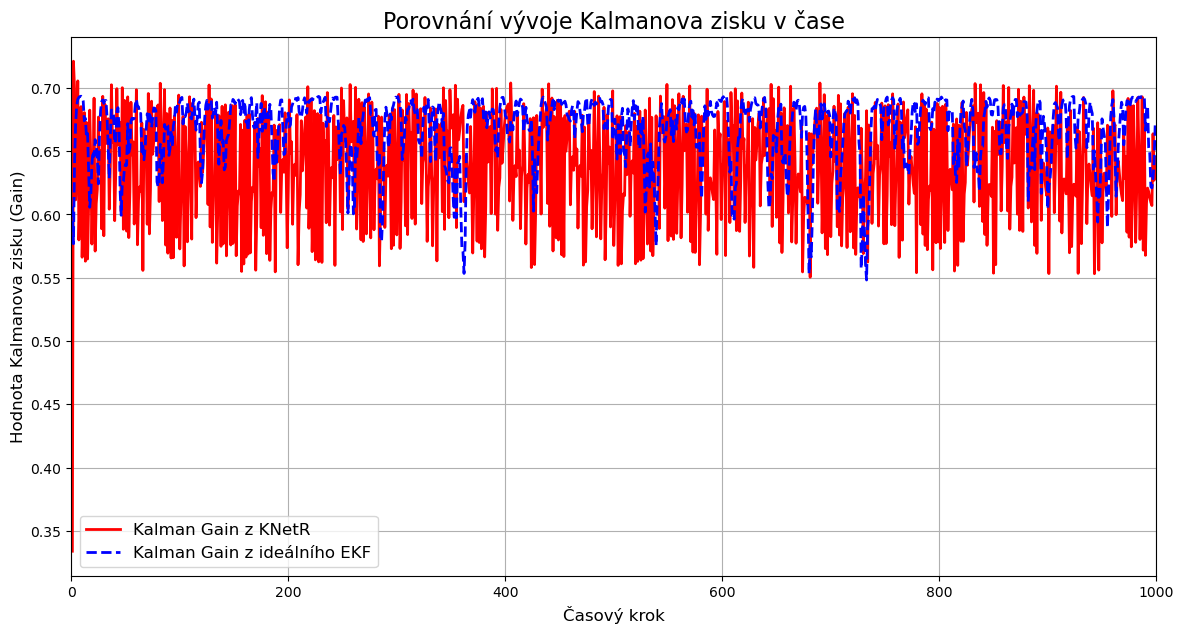

In [15]:
import matplotlib.pyplot as plt


TEST_SEQ_LEN = 1000
NUM_TEST_TRAJ = 1
J_SAMPLES_TEST = 25

# ==============================================================================
# 2. PŘÍPRAVA DAT
# ==============================================================================
print(f"\nGeneruji {NUM_TEST_TRAJ} testovacích trajektorií o délce {TEST_SEQ_LEN}...")
x_test, y_test = utils.generate_data(sys_true, num_trajectories=NUM_TEST_TRAJ, seq_len=TEST_SEQ_LEN)
test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# KROK 6: POROVNÁNÍ KALMANOVA ZISKU (GAIN)

print("="*80)
print("Provádím analýzu a porovnání Kalmanova zisku...")

# Vybereme jednu trajektorii pro analýzu (např. první z testovací sady)
# Použijeme data, která již byla vygenerována v buňce [6]
# x_true_traj = x_test[0].to(device) # Tvar [SEQ_LEN, state_dim]
# y_test_traj = y_test[0].to(device) # Tvar [SEQ_LEN, obs_dim]
x_true_traj = x_test.squeeze(0).to(device)
y_test_traj = y_test.squeeze(0).to(device)

with torch.no_grad():
    # 1. Získání historie z ideálního EKF
    # Předpokládáme, že `ekf_ideal` byl inicializován v buňce [23]
    # a že jeho metoda `process_sequence` vrací slovník s klíčem 'K_filtered'
    print("Spouštím ideální EKF pro získání referenčního Kalmanova zisku...")
    try:
        ekf_i_res = ekf_ideal.process_sequence(
            y_test_traj,
            Ex0=sys_true.Ex0,
            P0=sys_true.P0
        )
        # Tvar [SEQ_LEN - 1, state_dim, obs_dim]
        ekf_gain_history = ekf_i_res['Kalman_gain'].cpu()
        print("Historie z EKF úspěšně získána.")
    except KeyError:
        print("\nCHYBA: Zdá se, že vaše třída `ExtendedKalmanFilter` nevrací klíč 'Kalman_gain'.")
        print("Pro spuštění této buňky je nutné upravit metodu `process_sequence` tak, aby vracela i historii Kalmanova zisku.")
        ekf_gain_history = None
    except NameError:
        print("\nCHYBA: Objekt `ekf_ideal` nebyl nalezen. Ujistěte se, že jste spustili buňku [23].")
        ekf_gain_history = None


    # 2. Získání historie z natrénovaného KNetR
    # Předpokládáme, že `trained_model_knetR` je natrénovaný model
    print("Spouštím KNetR pro získání jeho Kalmanova zisku...")
    try:
        # Resetujeme model na počáteční stav dané trajektorie
        initial_state = x_true_traj[0, :].unsqueeze(0)
        trained_model_knetR.reset(batch_size=1, initial_state=initial_state)

        # Projdeme celou sekvenci a necháme model, aby si uložil historii
        for t in range(1, TEST_SEQ_LEN):
            y_t = y_test_traj[t, :].unsqueeze(0)
            trained_model_knetR.step(y_t)
        
        # Získáme historii pomocí nové metody
        # Tvar [SEQ_LEN - 1, state_dim, obs_dim]
        knetr_gain_history = trained_model_knetR.get_kalman_gain_history()
        print("Historie z KNetR úspěšně získána.")
    except NameError:
        print("\nCHYBA: Objekt `trained_model_knetR` nebyl nalezen. Ujistěte se, že jste úspěšně natrénovali model StateKalmanNetWithKnownR.")
        knetr_gain_history = None

# 3. Vykreslení grafu pro porovnání
if ekf_gain_history is not None and knetr_gain_history is not None:
    print("Vykresluji graf porovnání...")
    
    # V našem případě je state_dim=1 a obs_dim=1, takže zisk je skalár
    # Převedeme tenzory na 1D NumPy pole pro snadné vykreslení
    ekf_gains_to_plot = ekf_gain_history[1:].squeeze().numpy()
    knetr_gains_to_plot = knetr_gain_history.squeeze().numpy()

    time_steps = range(1, TEST_SEQ_LEN)

    plt.figure(figsize=(14, 7))
    plt.plot(time_steps, knetr_gains_to_plot, label='Kalman Gain z KNetR', color='r', linewidth=2)
    plt.plot(time_steps, ekf_gains_to_plot, label='Kalman Gain z ideálního EKF', color='b', linestyle='--', linewidth=2)
    
    plt.title('Porovnání vývoje Kalmanova zisku v čase', fontsize=16)
    plt.xlabel('Časový krok', fontsize=12)
    plt.ylabel('Hodnota Kalmanova zisku (Gain)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.xlim(0, TEST_SEQ_LEN)
    plt.show()

print("="*80)